<a href="https://colab.research.google.com/github/asalcedo31/CSC2516_project/blob/master/CSC_2516_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import numpy as np
import torch 
from PIL import Image
# from torch import torchvision
from keras.datasets import cifar100
import sklearn as sk
from sklearn import model_selection



Using TensorFlow backend.


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy



In [0]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
x_all = np.vstack((x_train,x_test))
y_all = np.vstack((y_train,y_test))

#splitting data by groups into training and testing by labels
g_train, g_test = next(sk.model_selection.GroupShuffleSplit(n_splits=1).split(x_all, y_all, groups=y_all))
x_full_train = x_all[g_train,]
x_test = x_all[g_test,]
y_full_train = y_all[g_train,]
y_test = y_all[g_test,]

#further splitting the training set into training and validation for hyper-parameter tuning
g_train, g_test = next(sk.model_selection.GroupShuffleSplit(n_splits=1).split(x_full_train, y_full_train, groups=y_full_train))
x_train = x_full_train[g_train,]
x_val = x_full_train[g_test,]
y_train = y_full_train[g_train,]
y_val = y_full_train[g_test,]


169009152/169001437 [==============================] - 8s 0us/step


In [0]:
class CIFAR100_by_label(Dataset):
  def __init__(self,x_data, y_data, transform=None):
    self.x = x_data
    self.y = y_data
    self.transform=transform

  def __len__(self):
    return(len(self.y))
  
  def __getitem__(self,idx):
    sample_x = self.x[idx,:,:,:]
    sample_y = self.y[idx]
    
    sample_x = Image.fromarray(sample_x,'RGB')  
    if(self.transform):      
      sample_x = self.transform(sample_x)
      sample_y = sample_y
    return (sample_x,sample_y)


In [0]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),        
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
train_dataset = CIFAR100_by_label(x_train, y_train, transform=data_transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4, shuffle=True)

val_dataset = CIFAR100_by_label(x_val, y_val, transform=None)
val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=4, shuffle=True)

test_dataset = CIFAR100_by_label(x_test, y_test, transform=None)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=4, shuffle=True)




In [0]:
train_iter = iter(train_data_loader)

#this is what gets called for each batch in the epoch
train_x, train_y = train_iter.next()#,"train")
print(train_y)
print(train_x)


tensor([[53],
        [41],
        [ 6],
        [83]])
tensor([[[[ 2.2318,  2.2318,  2.2318,  ...,  0.9988,  0.9988,  0.9988],
          [ 2.2318,  2.2318,  2.2318,  ...,  0.9988,  0.9988,  0.9988],
          [ 2.2318,  2.2318,  2.2318,  ...,  0.9988,  0.9988,  0.9988],
          ...,
          [ 2.1975,  2.1975,  2.1975,  ...,  1.4098,  1.4098,  1.4098],
          [ 2.1975,  2.1975,  2.1975,  ...,  1.4098,  1.4098,  1.4098],
          [ 2.1975,  2.1975,  2.1975,  ...,  1.4098,  1.4098,  1.4098]],

         [[ 0.9405,  0.9405,  0.9405,  ..., -0.5826, -0.5826, -0.5826],
          [ 0.9405,  0.9405,  0.9405,  ..., -0.5826, -0.5826, -0.5826],
          [ 0.9405,  0.9405,  0.9405,  ..., -0.5826, -0.5826, -0.5826],
          ...,
          [ 1.7458,  1.7458,  1.7458,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.7458,  1.7458,  1.7458,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.7458,  1.7458,  1.7458,  ..., -0.0224, -0.0224, -0.0224]],

         [[-0.4624, -0.4624, -0.4624,  ..., -

In [0]:
vgg16 = models.vgg16(pretrained=True) #perhaps we have to retrain the last layer so it predicts cifar not imagenet?
vgg16.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:19, 28157996.20it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
# with torch.no_grad():
pred = vgg16(train_x)


In [0]:
print(torch.max(pred,1))
print(train_y)

(tensor([ 9.4911, 11.9214,  7.3514,  8.2031], grad_fn=<MaxBackward0>), tensor([722, 491,  98, 653]))
tensor([[53],
        [41],
        [ 6],
        [83]])


https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

## Planning and pseudocode

Copying down the pseudocode / algorithms from the proposal for reference:


Algorithm1:

    θ ← Random initialization
    for all D in collection of datasets D do
        T ← Sample tasks from dataset D
        for all i in T do
            G_i ← ∇_{θ,i} L(f_{θ,i})
            θ_i ← θ_i − βG_i
        θ ← Pruned and fine-tuned θ

Algorithm2:

    for all D in collection of datasets D do
        θ ← Random initialization
        T ← Sample tasks from dataset D
        for all i in T do
            G_i ← ∇_{θ,i} L(f_{θ,i})
            θ_i ← θ_i − βG_i
        θ ← Pruned θ

Ideally, we need the following types of functions:

1. A wrapper function which calls the inner training look for whatever target architecture (e.g. vgg, or some toy architecture from assignments), so that we can easily swap in and out different models (e.g. start with a toy model, then proceed to vgg).

2. A function to actually perform pruning, given a pruning method. This way, we can swap in and out different pruning approaches.

Copying some functions over from the tutorial linked above

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

!unzip 'hymenoptera_data.zip'
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# image_datasets = [train_dataset, val_dataset]

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/bees/
  inflating: hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg  
   creating: __MACOSX/
   creating: __MACOSX/hymenoptera_data/
   creating: __MACOSX/hymenoptera_data/train/
   creating: __MACOSX/hymenoptera_data/train/bees/
  inflating: __MACOSX/hymenoptera_data/train/bees/._2638074627_6b3ae746a0.jpg  
  inflating: hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg  
  inflating: __MACOSX/hymenoptera_data/train/bees/._507288830_f46e8d4cb2.jpg  
  inflating: hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg  
  inflating: __MACOSX/hymenoptera_data/train/bees/._2405441001_b06c36fa72.jpg  
  inflating: hymenoptera_data/train/bees/2962405283_22718d9617.jpg  
  inflating: __MACOSX/hymenoptera_data/train/bees/._2962405283_22718d9617.jpg  
  inflating: hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg  
  inflating: __MACOSX/hymenoptera_dat

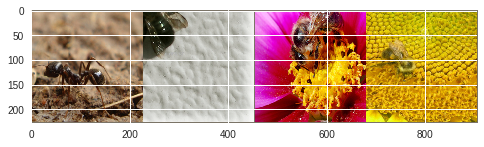

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

## Train function

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
#                 dataloader = train_data_loader
                model.train()  # Set model to training mode
                data_idx = 0
            else:
                model.eval()   # Set model to evaluate mode
#                 dataloader = val_data_loader
                data_idx = 1

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Model setup

In [0]:
model_ft = models.vgg16(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



## Run training

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5557 Acc: 0.4836
val Loss: 0.6979 Acc: 0.6797

Epoch 1/24
----------
train Loss: 0.9096 Acc: 0.5082
val Loss: 0.7617 Acc: 0.4902

Epoch 2/24
----------
train Loss: 0.8625 Acc: 0.5656
val Loss: 0.5536 Acc: 0.7190

Epoch 3/24
----------
train Loss: 0.7998 Acc: 0.6516
val Loss: 0.8848 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.6734 Acc: 0.6598
val Loss: 0.4976 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.6523 Acc: 0.7049
val Loss: 0.4775 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.6356 Acc: 0.6762
val Loss: 0.5314 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.4812 Acc: 0.7746
val Loss: 0.4850 Acc: 0.8170

Epoch 8/24
----------
train Loss: 0.4449 Acc: 0.7951
val Loss: 0.4812 Acc: 0.7712

Epoch 9/24
----------
train Loss: 0.4340 Acc: 0.8115
val Loss: 0.4448 Acc: 0.8301

Epoch 10/24
----------
train Loss: 0.3934 Acc: 0.8320
val Loss: 0.4410 Acc: 0.8235

Epoch 11/24
----------
train Loss: 0.3930 Acc: 0.8443
val Loss: 0.4856 Acc: 0.8235

Ep

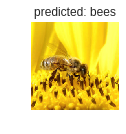

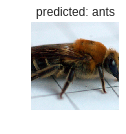

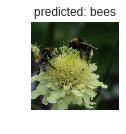

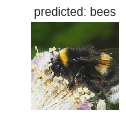

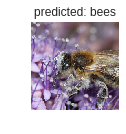

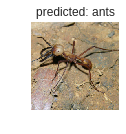

In [0]:
visualize_model(model_ft)

In [0]:
for param in model+_ft.parameters():
>>>     print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([64, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128, 3, 3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([256, 128, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([256, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([256, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([512, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 512, 3, 3])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 512, 3, 3])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 512, 3, 3])
<class 'torch.Tensor'> tor

Ways to freeze individual weights

https://discuss.pytorch.org/t/freezing-part-of-the-layer-weights/9457

